#### DNN 기반 다중분류 모델 구현
- 데이터셋 : iris.csv
- Feature : 4개 Sepal_Length, Sepal_Width, Petal_Length, Petal_Width
- Target : 1개 Variety
- 학습-방법 : 지도학습 > 분류 > 다중분류 (클래스 3개)
- 알고리즘 : 인공신경망(ANN) => MLP, DNN : 은닉층이 많은 구성
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [91]:
# 모델 관련 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# Data 관련 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [92]:
# 활용 패키지 버전 체크 => 사용자 정의 함수로 구현하기
print(f'Pytorch V. {torch.__version__}')
print(f'Pandas V. {torch.__version__}')

Pytorch V. 2.4.1
Pandas V. 2.4.1


In [93]:
# 데이터 로딩
DATA_FILE='../data/iris.csv'

# CSV => DataFrame
irisDF=pd.read_csv(DATA_FILE)

# 데이터 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [94]:
# 타겟 변경 => 정수화, 클래스 3개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [95]:
labels=dict(zip(irisDF['variety'].unique().tolist(),range(3)))
print(f'labels => {labels}')

irisDF['variety']=irisDF['variety'].replace(labels)
irisDF.head(1)

labels => {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0


[2] 모델 클래스 설계 및 정의<hr>
- 클래스목적 : iris 데이터를 학습 및 추론 목적 
- 클래스이름 : IrisMCFModel
- 부모클래스 : nn.Module
- 매개변수 : 층별 입출력 개수 고정하기때문에 필요 없음
- 속성필드 : 
- 기능역할 : __init__() : 모델 구조, forward() : 순방향 학습 <= 오버라이딩
- 클래스구조
    * 입력층 : 입력  4개(피처)  출력 10개(퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개        출력 5개(퍼셉트론/뉴런 5개 존재)
    * 출력층 : 입력  5개        출력 1개(퍼셉트론/뉴런 1개 존재 : 2진분류)

- 활성화함수
    * 클래스형태 => nn.MESLoss, nn.ReLU => __init__() 메서드
    * 함수형태 => torch.nn.fuctional 아래에 => forward() 메서드

In [96]:
class IrisMCFModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer=nn.Linear(4,10)
        self.hd_layer=nn.Linear(10,5)
        self.out_layer=nn.Linear(5,3) # 다중분류 'Setosa', 'Versicolor', 'Virginica' 

    # 순방향 학습 진행 메서드
    def forward(self, x):
        y=F.relu(self.in_layer(x))
        y=F.relu(self.hd_layer(y))
        return self.out_layer(y) # 5개의 숫자 값 => 다중분류 : 손실함수 CrossEntrpyLoss가 내부에서 softmax 진행

In [97]:
# 모델 인스턴스 생성
model=IrisMCFModel()

print(model)

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [98]:
# 모델 사용 메모리 정보 확인
summary(model, input_size=(1000,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [1000, 3]                 --
├─Linear: 1-1                            [1000, 10]                50
├─Linear: 1-2                            [1000, 5]                 55
├─Linear: 1-3                            [1000, 3]                 18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.02
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.16

[3] 데이터셋 클래스 설계 및 정의<hr>
- 데이터셋 : iris.csv
- 피쳐개수 : 4개
- 타겟개수 : 1개
- 클래스이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성필드 : featureDF, targetDF, n_rows, n_features
- 필수메서드
    * __init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __len__(self) : 데이터의 개수 반환
    * __getitem__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [99]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        # 넘파이를 텐서로
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

[3-1] 데이터셋 인스턴스 생성 <hr>

In [100]:
# 피쳐, 타겟 추출
featureDF, targetDF=irisDF[irisDF.columns[:-1]], irisDF[irisDF.columns[-1:]]
print(f'featureDF => {featureDF.shape}, targetDF => {targetDF.shape}')

# 데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF, targetDF)

featureDF => (150, 4), targetDF => (150, 1)


[4] 학습 준비
- 학습 횟수 : EPOCH <= 처음부터 끝까지 학습하는 단위
- 배치 크기 : BATCH_SIZE <= 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE <= 텐서 저장 및 실행 위치 (GPU/CPU)
- 학습률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1

In [101]:
# 학습 진행 관련 설정
EPOCH=1000
BATCH_SIZE=10
BATCH_CNT=irisDF.shape[0]/BATCH_SIZE
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
LR=0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (+ 손실함수, 성능지표)

In [102]:
# 모델 인스턴스
model=IrisMCFModel()

# 데이터셋 인스턴스

# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, random_state=1)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')

trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# 데이터로드 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)


- 최적화, 손실함수 인스턴스 생성

In [103]:
# 최적화 인스턴스 => W, b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(),lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss
#                            예측값은 선형식 결과값으로 전달 => AF 처리 X
crossLoss=nn.CrossEntropyLoss()

[5] 학습 준비

In [104]:
## 모델 파일 관련
### models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os

# 저장 경로
SAVE_PATH = '../models/iris/MCF/'
# 저장 파일명
SAVE_FILE=SAVE_PATH+'model_train_wbs.pth'

# 모델 구조 및 파라미터 모두 저장 파일명명
SAVE_MODEL=SAVE_PATH+'model_all.pth'

In [105]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)   # 폴더 / 폴더/.. 하위폴더까지 생성

In [106]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTROY=[[],[]], [[],[]]

f1_score_metric = MulticlassF1Score(num_classes=3)
# 중단 기준
BREAK_CNT =0
for epoch in range(1,EPOCH+1):
    # 학습 모드로 모델 설정
    model.train()

    # 배치크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0, 0
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산 : nn.CrossEntropyLoss 요구사항 : 정답/타겟은 0D 또는 1D, 타입은 long
        loss=crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()

        # 성능평가 계산
        score=f1_score_metric(pre_y, targetTS.reshape(-1))
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 추론/평가
        pre_val=model(val_featureTS)

        # 손실
        loss_val=crossLoss(pre_val, val_targetTS.reshape(-1).long())

        # 성능평가
        score_val=MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))
    
    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/BATCH_CNT)
    SCORE_HISTROY[0].append(score_total/BATCH_CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTROY[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} [SCORE] : {SCORE_HISTROY[0][-1]}')
    print(f'[{epoch}/{EPOCH}]\n- [VAL] LOSS : {LOSS_HISTORY[1][-1]} [SCORE] : {SCORE_HISTROY[1][-1]}')


    # 학습이 잘안되면 중단
    # LOSS를 기준으로 중단

    if len(LOSS_HISTORY[1]) >=2:
        if LOSS_HISTORY[1][-1] >= LOSS_HISTORY[1][-2]:
            BREAK_CNT +=1

    if len(LOSS_HISTORY[1]) ==1:
        # 첫번째라서 무조건 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 저장
        torch.save(model, SAVE_MODEL)
    else:
        if LOSS_HISTORY[1][-1] < min(LOSS_HISTORY[1]):      # 현재 에포크를 포함하여 전체 검증 손실에서 최소값 찾음음
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)
            
    # 학습 중단 여부 설정
    if BREAK_CNT >10 :
        print("성능 및 손실 개선이 없어서 학습")
        break

[1/1000]
- [TRAIN] LOSS : 0.7057619015375773 [SCORE] : 0.09865283071994782
[1/1000]
- [VAL] LOSS : 1.3174775838851929 [SCORE] : 0.10101010650396347
[2/1000]
- [TRAIN] LOSS : 0.6935278892517089 [SCORE] : 0.09865283071994782
[2/1000]
- [VAL] LOSS : 1.2845618724822998 [SCORE] : 0.10101010650396347
[3/1000]
- [TRAIN] LOSS : 0.6839449683825175 [SCORE] : 0.09865283071994782
[3/1000]
- [VAL] LOSS : 1.2570594549179077 [SCORE] : 0.10101010650396347
[4/1000]
- [TRAIN] LOSS : 0.6767165025075277 [SCORE] : 0.09865283071994782
[4/1000]
- [VAL] LOSS : 1.2346842288970947 [SCORE] : 0.10101010650396347
[5/1000]
- [TRAIN] LOSS : 0.6712969700495403 [SCORE] : 0.09865283071994782
[5/1000]
- [VAL] LOSS : 1.2164554595947266 [SCORE] : 0.10101010650396347
[6/1000]
- [TRAIN] LOSS : 0.6671454509099325 [SCORE] : 0.09865283071994782
[6/1000]
- [VAL] LOSS : 1.201358437538147 [SCORE] : 0.10101010650396347
[7/1000]
- [TRAIN] LOSS : 0.6638283650080363 [SCORE] : 0.09999963243802389
[7/1000]
- [VAL] LOSS : 1.188531994819

[3] 예측

In [107]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featureTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)

    # 추론/평가
    pre_val=model(test_featureTS)
    print(pre_val)

    # 손실
    loss_test=crossLoss(pre_val, test_targetTS.reshape(-1).long())

    # 성능평가
    score_test=MulticlassF1Score(num_classes=3)(pre_val, test_targetTS.reshape(-1))

tensor([[ 1.3340e+01,  1.0752e+00, -1.7030e+01],
        [-3.4867e+00,  1.9029e+00, -5.6810e+00],
        [-8.8647e+00,  2.6510e+00, -4.5921e+00],
        [ 1.2178e+01,  1.0020e+00, -1.5562e+01],
        [-2.1906e+01,  5.4833e-02,  1.8794e+00],
        [-1.2635e+01,  1.6654e+00, -2.1426e+00],
        [-1.9420e+01, -3.3531e-01,  2.1551e+00],
        [ 8.9118e+00,  1.1320e+00, -1.3198e+01],
        [ 9.6848e+00,  9.2122e-01, -1.2813e+01],
        [-2.3739e+01, -1.4731e+00,  4.8034e+00],
        [-1.0614e+01,  1.6544e+00, -2.2942e+00],
        [ 1.0914e+01,  1.0301e+00, -1.4531e+01],
        [-2.3714e+01, -1.3736e+00,  4.6799e+00],
        [-1.0322e+01,  2.3512e+00, -3.6686e+00],
        [-1.2493e+01,  1.3667e+00, -1.5887e+00],
        [ 1.0168e+01,  8.7539e-01, -1.3023e+01],
        [-8.0315e+00,  2.4027e+00, -4.0656e+00],
        [-1.3530e+01,  9.1984e-01, -6.3006e-01],
        [ 1.1115e+01,  9.3500e-01, -1.4218e+01],
        [ 1.1177e+01,  9.3895e-01, -1.4298e+01],
        [-1.2030e+01

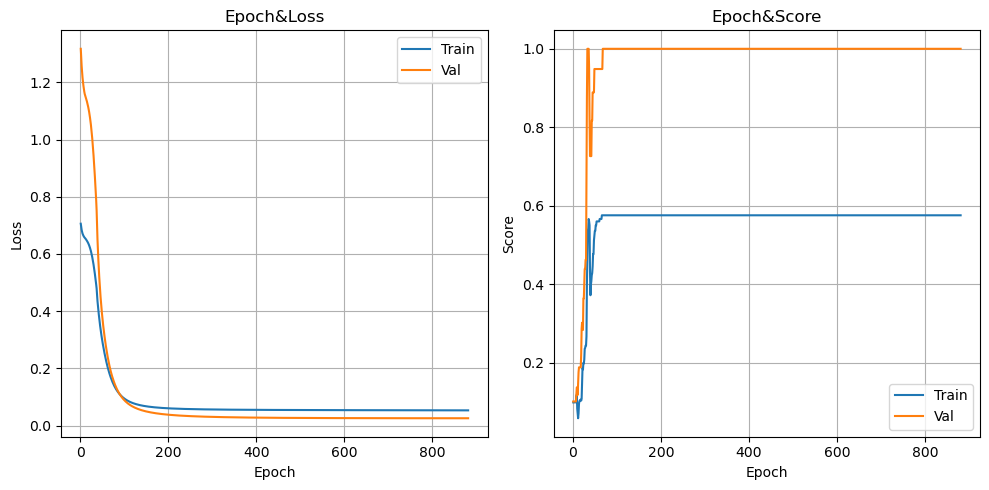

In [116]:
# 학습 후 loss 시각화

THRESHOLD=len(LOSS_HISTORY[1])
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), LOSS_HISTORY[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), LOSS_HISTORY[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), SCORE_HISTROY[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), SCORE_HISTROY[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Epoch&Score')
plt.tight_layout()
plt.show()